In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
from collections import Counter
np.set_printoptions(suppress=True)

/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [126]:
dat = np.array([0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0])

In [127]:
S = len(dat) -1
V = dat.sum()
print(S, V)

37 72


In [105]:
dat = np.array([0,25,22,13,5,1,2])
S = 6
V = dat.sum()
print(S, V)

6 68


In [1451]:
from scipy.special import gammaln

In [1555]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
#data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

In [1557]:
max(df['period'])

35

In [1169]:
S = 35
dat = np.zeros(S + 1)
out = Counter(data['count'].values)

In [1170]:
for k,v in out.items():
    dat[k] = v
V = len(workers)
print(S, V)

35 46145


In [1071]:
dat = [0,25,22,13,5,1,2]
S = 6 
V = 68
print(S, V)

6 68


In [1072]:
def logp_capture(alpha, beta, U, D, S):
    def ll_capture_f(ni):
        
        # useful vars
        i = tt.arange(S + 1)
        
        # At least one capture
        # binomln(n, k) + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
        
        #binomln
        Li =  tt.gammaln(S + 1) - tt.gammaln(i + 1) - tt.gammaln(S - i + 1)
        
        # betaln(i + alpha, n - i + beta)
        # betaln = gammaln(x) + gammaln(y) - gammaln(x + y)
        
        Li += tt.gammaln(i + alpha) + tt.gammaln(S - i + beta) - tt.gammaln(S + alpha + beta)
        
        # - betaln(alpha, beta)
        # gammaln(x) + gammaln(y) - gammaln(x + y)
        
        Li += tt.gammaln(alpha + beta) - tt.gammaln(alpha) - tt.gammaln(beta)
        
        # No captures
        #(betaln(alpha, S + beta) - betaln(alpha, beta))
        
        L0  = tt.gammaln(S + beta) - tt.gammaln(S + alpha + beta) + tt.gammaln(alpha + beta) - tt.gammaln(beta)
        
        # Likelihood
        obj1 = tt.gammaln(D+U+1) - tt.gammaln(U+1.0) - tt.sum(tt.gammaln(ni+1))
        obj2 = tt.sum(tt.mul(ni, Li))
        obj3 = U * L0
        objective = obj1 + obj2 + obj3 
        
        #print(tt.exp(Li).eval())
        return objective
    
    return ll_capture_f

In [1073]:
# custom log-liklihood model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=0, upper=200)
    a = pm.Uniform('alpha', 0., 100.)
    b = pm.Uniform('beta', 0., 100.)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(a, b, U, V, S), observed=dat)

INFO (theano.gof.compilelock): Refreshing lock /Users/ded/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock


In [1074]:
with model:
  posterior = pm.sample(5000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, Unseen]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:12<00:00, 1701.67draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6291558947883568, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [1075]:
with model:
  ma = pm.find_MAP()

logp = -27.703, ||grad|| = 6.9654: 100%|██████████| 30/30 [00:00<00:00, 3146.99it/s]   


In [1076]:
ma

{'Unseen_interval__': array(-2.04967863),
 'alpha_interval__': array(-3.98109186),
 'beta_interval__': array(-2.9374685),
 'Unseen': array(22.81697166),
 'alpha': array(1.83232405),
 'beta': array(5.03321385)}

/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


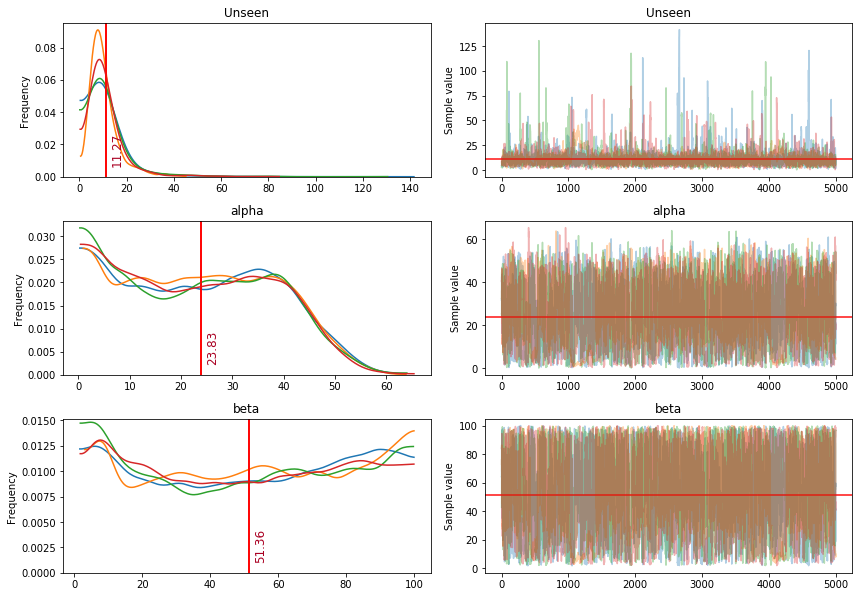

In [1077]:
plot_traces(posterior)

In [1078]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,11.265917,8.963704,0.266914,0.770677,25.150531,1046.191124,1.002379
alpha,23.833471,14.561404,0.455335,0.387871,47.068452,818.791707,1.000519
beta,51.357745,29.639618,0.948311,3.499479,96.875404,770.040908,1.000694


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c292e1b00>,
      dtype=object)

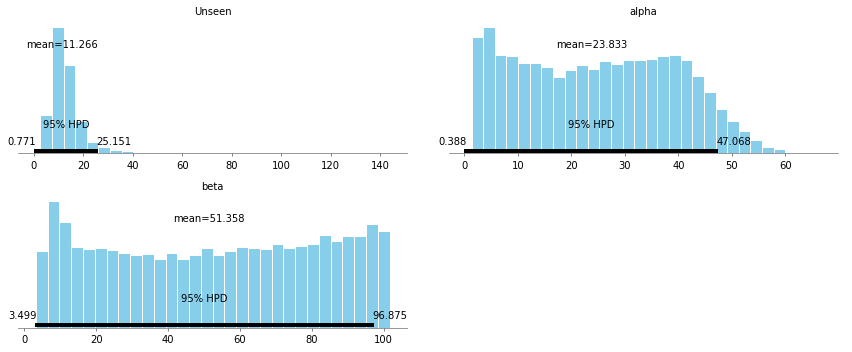

In [1079]:
pm.plot_posterior(posterior)

<BarContainer object of 7 artists>

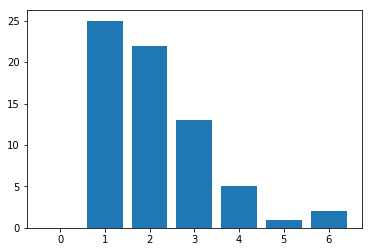

In [1080]:
plt.bar(np.arange(len(dat)), dat)

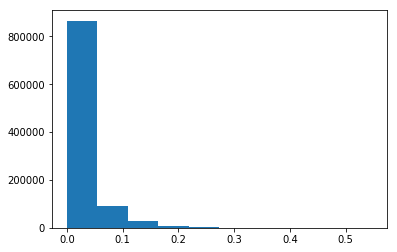

In [145]:
plt.hist(pm.Beta.dist(alpha = 0.33, beta = 14).random(size = 1000000));

In [93]:
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
import time

In [135]:
initParams = np.array([100, 100, 1000])

In [136]:
results = minimize(logp_capture, initParams, method='nelder-mead')

In [137]:
results

 final_simplex: (array([[-336.6666956 ,  331.6666956 , 2383.33339226],
       [-336.66669559,  331.66669559, 2383.33339224],
       [-336.66669558,  331.66669558, 2383.33339224],
       [-336.66669558,  331.66669558, 2383.33339223]]), array([-8061362.48454037, -8061362.48448832, -8061362.48447421,
       -8061362.48446407]))
           fun: -8061362.484540369
       message: 'Optimization terminated successfully.'
          nfev: 301
           nit: 134
        status: 0
       success: True
             x: array([-336.6666956 ,  331.6666956 , 2383.33339226])

In [83]:
dat

array([ 0, 25, 22, 13,  5,  1,  2])

In [112]:
np.arange(S + 1)

array([0, 1, 2, 3, 4, 5, 6])

In [159]:
np.power(.99999999999999,100000000)

0.999999000799777

In [167]:
gammaln(12)

17.502307845873887

In [184]:
alpha = 10000
beta = 10
S = 36
gammaln(S + beta) - gammaln(S + alpha + beta) + gammaln(alpha + beta) - gammaln(beta)

-215.3489920375395

In [185]:
gamma

NameError: name 'gamma' is not defined

In [189]:
from scipy.special import gamma

In [275]:
alpha = .0001
beta = 10
S = 36
( gamma(S + beta) * gamma(alpha + beta) ) / ( gamma(S + alpha + beta) * gamma(beta))

0.999843414690532

In [276]:
f0 = 500
V = 50


5535.7812618870885

In [914]:
def gm(T, K, alpha, beta):
    Li = 0
    for i in range(1, len(K)):
        k = i
        Li += K[i] * (gammaln(k + alpha)+gammaln(T-k+beta)+gammaln(alpha + beta) - gammaln(T + alpha + beta)-gammaln(alpha)-gammaln(beta))
    return Li    

In [761]:
len(dat)

38

In [737]:
sum(dat)

72

In [763]:
dat = [0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0]
alpha = .3979
beta = 3.4101
S = 50
D = 72
f0 = 34
N = gammaln(D + f0 +1) - gammaln(f0+1) 
L0 = f0 * (gammaln(S + beta) - gammaln(S + alpha + beta) + gammaln(alpha + beta) - gammaln(beta))
Lk = gm(S, dat, alpha, beta)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

302.9951606751319 -29.059913253995305 -1375.9682225494507 

Likelihood: -1102.032975128314 

Estimate: 106


In [1218]:
def gm(T, K, alpha, beta):
    Li = 0
    for i in range(1, len(K)):
        k = i
        Li += K[i] * (gammaln(k + alpha)+gammaln(T-k+beta)+gammaln(alpha + beta) - gammaln(T + alpha + beta)-gammaln(alpha)-gammaln(beta))
    return Li   

alpha = 1.9
beta = 15
S = 6 
D = 68
f0 = 32

N = gammaln(D + f0 +1) - gammaln(f0+1) 
L0 = f0 * (gammaln(S + beta) - gammaln(S + alpha + beta) + gammaln(alpha + beta) - gammaln(beta))
Lk = gm(S, [0,25,22,13,5,1,2], alpha, beta)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

282.1814160994484 -19.962768203206565 -329.9280182917158 

Likelihood: -67.70937039547391 

Estimate: 100


In [1217]:
# Alpha Beta version
def gm(T, K, alpha, beta):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + alpha)+gammaln(T - k + beta))
    return Li   

alpha = 1.9
beta = 15
S = 6 
D = 68
f0 = 32

N = gammaln(D + f0 +1) - gammaln(f0+1) 
L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
Lk = gm(S, [0,25,22,13,5,1,2], alpha, beta)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

282.1814160994484 -2938.5546392034876 2588.663852708565 

Likelihood: -67.7093703954738 

Estimate: 100


In [1166]:
# Mu Tau version
def gtaumu(T, K, mu, tau):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + (tau*mu)) + gammaln(T - k + (tau * (1-mu))) )
    return Li    

alpha = 1.9
beta = 15
S = 6 
D = 68
f0 = 32

mu = alpha / (alpha + beta)
tau = alpha + beta

N = gammaln(D + f0 +1) - gammaln(f0+1)
L0 = (f0 + D) * (gammaln(tau) - gammaln(tau*mu) - gammaln(tau * (1-mu)) - gammaln(S + tau))
L0 += f0 * (gammaln(tau*mu) + gammaln(S + (tau*(1-mu))))
Lk = gtaumu(S, [0,25,22,13,5,1,2], mu, tau)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

282.1814160994484 -2938.5546392034876 2588.663852708565 

Likelihood: -67.7093703954738 

Estimate: 100


In [1310]:
def gtaumu(T, K, mu, tau):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + (tau*mu)) + gammaln(T - k + (tau * (1-mu))) )
    return Li    

alpha = .9
beta = 1

S  = 36
D  = 46145
f0 = 100000

mu = alpha / (alpha + beta)
tau = alpha + beta

N = gammaln(D + f0 +1) - gammaln(f0+1)
L0 = (f0 + D) * (gammaln(tau) - gammaln(tau*mu) - gammaln(tau * (1-mu)) - gammaln(S + tau))
L0 += f0 * (gammaln(tau*mu) + gammaln(S + (tau*(1-mu))))
Lk = gtaumu(S, dat, mu, tau)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

540570.8001732698 -4900514.330231082 4142960.464353323 

Likelihood: -216983.06570448913 

Estimate: 146145


In [1314]:
# Alpha Beta version
def gm(T, K, alpha, beta):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + alpha)+gammaln(T - k + beta))
    return Li  

alpha = 50000
beta = 1

S  = 36
D  = 46145
f0 = 10000

L0 = 0
N = gammaln(D + f0 +1) - gammaln(f0 + 1)
L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
Lk = gm(S, dat, alpha, beta)
print(N, L0, Lk, '\n')
print("Likelihood:", N + L0 + Lk, '\n')
print("Estimate:", D + f0)

475736.93732583517 -22677388914.85477 22661630106.84 

Likelihood: -15283071.077445984 

Estimate: 56145


In [1172]:
len(dat)

36

u = a / a +b  , t = a+b
a = t - b
b = t - a
ua + ub = a
ut - ub +ub = ut = a
a = ut
b = t - ut = (1-u) t

In [949]:
u=0.267 
t=6.86
a = u * t
b = t * (1-u)
print(a, b)


1.8316200000000002 5.02838


In [682]:
gammaln(D+f0+1), gammaln(f0+1)

(12194848.425258968, 12126014.20144514)

In [1173]:
dat

array([    0., 30424.,  6905.,  2879.,  1569.,  1033.,   685.,   480.,
         372.,   284.,   221.,   185.,   192.,   126.,   114.,    90.,
          83.,    83.,    58.,    43.,    66.,    38.,    37.,    29.,
          31.,    31.,    22.,    22.,    10.,    10.,     8.,     6.,
           5.,     4.,     0.,     0.])

In [416]:
def gmm(T, K, alpha, beta):
    Li = 0
    for i in range(1, len(K)):
        k = i
        Li += K[i] * (gammaln(k + alpha)+gammaln(T-k+beta)+gammaln(alpha + beta) - gammaln(T + alpha + beta)-gammaln(alpha)-gammaln(beta))
    return Li   

In [535]:
alpha = 
beta  = 10
S  = 360
D  = 46145
f0 = 45000

C  = gammaln(D + f0 +1) - gammaln(f0+1) 
L0 = f0 * (gammaln(S + beta) - gammaln(S + alpha + beta) + gammaln(alpha + beta) - gammaln(beta))
Lk = gmm(S, dat, alpha, beta)

print("Parameters:", S, D, f0, '\n')
print(C, L0, Lk, '\n')
print(C + L0 + Lk)

Parameters: 360 46145 45000 

512601.3133847537 -626392.8436104478 -1059964.5305132996 

-1173756.0607389938


In [617]:
alpha = .17
beta  = 14
S  = 36
D  = 46145
f0 = 40000

def mle(initParams, rel = False):
    alpha = initParams[0]#/1000000
    if rel:
        alpha = alpha / 1000000
    beta = initParams[1]
    f0 = initParams[2]
    C  = gammaln(D + f0 +1) - gammaln(f0+1) 
    L0 = f0 * (gammaln(S + beta) - gammaln(S + alpha + beta) + gammaln(alpha + beta) - gammaln(beta))
    Lk = gmm(S, dat, alpha, beta)
    obj = C + L0 + Lk
    #print(obj, alpha, beta, f0)
    return -obj

In [616]:
initParams = [.5, 10, 100003]
bnds = ((0.000001, None), (0.01, None), (1, None))
results = minimize(mle, initParams, method='BFGS', bounds = bnds, options=dict({'epsilon' : }))
results

/Users/ded/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/ded/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: OptimizeWarning: Unknown solver options: epsilon
  This is separate from the ipykernel package so we can avoid doing imports until


      fun: -14394455.762733398
 hess_inv: array([[ 0.00094842, -0.00088571, -0.00337655],
       [-0.00088571,  0.00084805,  0.00321831],
       [-0.00337655,  0.00321831,  1.01911445]])
      jac: array([-230076.875, -278012.875,     -95.125])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 449
      nit: 4
     njev: 89
   status: 2
  success: False
        x: array([  -120.88525374,     93.41880931, 100087.04671005])

In [597]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [646]:
x = np.linspace(1, 1000000, 500)
y = np.linspace(1, 1000000, 500)
X, Y = np.meshgrid(x, y)

In [647]:
Z = mle([X, 10, Y], True)

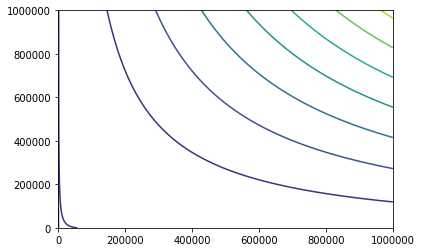

In [648]:
plt.contour(X, Y, Z)

In [632]:
np.vstack([X.ravel(), Y.ravel()]).shape

(2, 2500)

In [651]:
Z.min()

-113827.15907637292

In [1148]:
alpha = 1.9
beta = 15

S = 6 
D = 68
f0 = 32

def mlen(initParams, rel = False):
    alpha = initParams[0]#/1000000
    if rel:
        alpha = alpha / 1000000
    beta = initParams[1]
    f0 = initParams[2]
  
    mu = alpha / (alpha + beta)
    tau = alpha + beta
    
    C = gammaln(D + f0 +1) - gammaln(f0+1)
    L0 = (f0 + D) * (gammaln(tau) - gammaln(tau*mu) - gammaln(tau * (1-mu)) - gammaln(S + tau))
    L0 += f0 * (gammaln(tau*mu) + gammaln(S + (tau*(1-mu))))
    Lk = gtaumu(S, [0,25,22,13,5,1,2], alpha, beta)
    obj = C + L0 + Lk
    print(alpha, beta, f0, -obj)
    return -obj

In [1769]:
# Alpha Beta version
def gm(T, K, alpha, beta):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + alpha)+gammaln(T - k + beta))
    return Li   

S  = 35
D  = 46145

def mll(initParams):
    alpha = initParams[0]
    beta = initParams[1]
    f0 = np.exp(initParams[2])
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
    L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
    Lk = gm(S, dat, alpha, beta)
    obj = N + L0 + Lk
    #print(alpha, beta, f0, -obj)
    return -obj

initParams = np.array([.5,1,10])
B= ((.00000001, None), (1, None), (1, None))
#res = minimize(mll, initParams, method = 'TNC', bounds = B)
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)
res = scipy.optimize.basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(np.exp(res['x'][2]) + D)

                        fun: -117214.74993509427
 lowest_optimization_result:       fun: -117214.74993509427
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-506.1738193 , -314.60076571, -381.46972656])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 92
      nit: 7
   status: 0
  success: True
        x: array([ 0.00006254, 10.06023517, 19.98817997])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1
                       nfev: 14896
                        nit: 100
                          x: array([ 0.00006254, 10.06023517, 19.98817997])
479510432.8329042


In [ ]:
mll([     0.0515    ,     10.85245336, 586639.75185021])

In [1765]:
S  = 35
D  = 46145

def mllBin(initParams):
    f0 = np.exp(initParams[0])
    p = initParams[1]
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    Lk = f0 * S * np.log(1-p)
    for j in range(1, len(dat)):
        Lk += dat[j] * ( (j * np.log(p)) + ((S-j) * np.log(1-p)) )
        
    obj = N + Lk
    #print(-obj, p, f0)
    return -obj

initParams = np.array([1,1])
B= ((1, None), (0.00001, 0.999))
minimizer_kwargs = dict(method="L-BFGS-B", bounds=B)
res = scipy.optimize.basinhopping(mllBin, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(np.exp(res['x'][0]) + D)

                        fun: -78823.89312218159
 lowest_optimization_result:       fun: -78823.89312218159
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.18626451])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 24
   status: 0
  success: True
        x: array([8.99199341, 0.0530573 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 7083
                        nit: 100
                          x: array([8.99199341, 0.0530573 ])
54183.4648756839


In [1521]:
len(dat)

36

In [1446]:
birds = np.array([0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0])

alpha = .55
beta = 30

S  = 36
D  = 72
f0 = 20

def mll(initParams):
    alpha = initParams[0]
    beta = initParams[1]
    f0 = initParams[2]
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
    L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
    Lk = gm(S, birds, alpha, beta)
    obj = N + L0 + Lk
    #print(alpha, beta, f0, obj)
    return -obj

initParams = np.array([1,1,1])
B= ((.0515, 1), (0, 30), (1, None))
res = minimize(mll, initParams, method = 'L-BFGS-B', bounds = B, options = {'eps': 0.1})
res

      fun: 865.6454392681144
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.9143559 , -0.32434813, -0.30158524])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 14
   status: 0
  success: True
        x: array([ 0.38655453,  1.80604789, 19.08719115])

In [1492]:
#birds = np.array([0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0])
birds = np.array([0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

#alpha = .55
#beta = 30

S  = 50
D  = 72
f0 = 20

def mll(initParams):
    mu = initParams[0]
    om = initParams[1]
    f0 = initParams[2]
    #mu = alpha / (alpha + beta)
    #om = 1 / (alpha + beta)
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    
    for j in range(0, S + 1):
        #Pj
        Lk = 0
        for r in range(0, j):
            Lk += mu + (r * om)
        for r in range(0, S - j):
            Lk += 1 - mu + (r * om)
        for r in range(0, S):
            Lk -= 1 + (r*om)
            
        if j == 0:
            Lk = Lk * f0
        else:
            Lk = Lk * birds[j]
            
        N = N + Lk
    
    #print(alpha, beta, f0, N)
    return -N

initParams = np.array([1,1,1])
B= (( 0, None), (0, None), (1, None))
res = minimize(mll, initParams, method = 'L-BFGS-B')
res

      fun: -4.0528151299276826e+20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 4
   status: 0
  success: True
        x: array([-1.26898470e+11, -9.45203842e+11,  6.38720511e+07])

In [1493]:
mll([ 0.1045 , 0.2626, 34])

5665.857639324873

In [1490]:
len(np.array([0,11,12,10,4,4,1,4,2,3,3,0,2,4,1,1,0,1,1,1,2,0,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))

51

In [1513]:
birds = np.array([0, 679, 531, 379, 272, 198, 143, 99,67, 46, 32, 22, 14, 9, 5, 3, 1, 0, 0, 0, 0])

alpha = .55
beta = 30

S  = 20
D  = 2500
f0 = 20

def mll(initParams):
    alpha = initParams[0]
    beta = initParams[1]
    f0 = initParams[2]
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
    L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
    Lk = gm(S, birds, alpha, beta)
    obj = N + L0 + Lk
    return -obj

initParams = np.array([1,1,1])
B= ((.001, 1), (0, None), (1, None))
res = minimize(mll, initParams, method = 'L-BFGS-B', bounds = B)
print(res)
print((2 * 3) - (2 * -res['fun']), D + res['x'][2])

      fun: 4731.478491730901
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.33032848,  0.06693881,  0.00291038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 212
      nit: 29
   status: 0
  success: True
        x: array([  0.88910343,   6.46603246, 990.92157448])
9468.956983461801 3490.921574482495


In [1628]:
np.exp(np.log(10))

10.000000000000002

In [1762]:
# Snowhoe

snow = np.array([ 0, 25, 22, 13,  5,  1,  2])

# Alpha Beta version
def gm(T, K, alpha, beta):
    Li = 0
    for k in range(1, len(K)):
        Li += K[k] * (gammaln(k + alpha)+gammaln(T - k + beta))
    return Li   


S  = 6
D  = sum(snow)

def mll(initParams):
    alpha = initParams[0]
    beta = initParams[1]
    f0 = np.exp(initParams[2])
    N = gammaln(D + f0 +1) - gammaln(f0 + 1)
    L0 = (f0+D) * (gammaln(alpha + beta) - gammaln(S + alpha + beta) - gammaln(beta) - gammaln(alpha))
    L0 += f0 * (gammaln(S + beta)  +  gammaln(alpha) )
    Lk = gm(S, snow, alpha, beta)
    obj = N + L0 + Lk
    #print(alpha, beta, f0, N, L0, Lk, obj)
    return -obj

initParams = np.array([1, 1,.01])
B= ((0.000001, None), (.1, None), (0, None))
minimizer_kwargs = dict(method="L-BFGS-B" , bounds=B)
res = scipy.optimize.basinhopping(mll, initParams, minimizer_kwargs=minimizer_kwargs)
print(res)
print(np.exp(res['x'][2]) + D)

                        fun: 36.69379621812186
 lowest_optimization_result:       fun: 36.69379621812186
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00001137,  0.00001137,  0.00004547])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 68
      nit: 13
   status: 0
  success: True
        x: array([1.83233207, 5.0332307 , 3.12750294])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 7212
                        nit: 100
                          x: array([1.83233207, 5.0332307 , 3.12750294])
90.81693311057901


In [1723]:
sum(snow)

68

In [1725]:
np.log(3.12)

1.1378330018213911

In [1727]:
mll([1.83232565, 5.03322132, 3.12750686])

36.69379621811879

In [1732]:
mll([1.83232565, 5.03322132, np.log(3.12750686)])

51.19074694000585

In [1735]:
np.exp(np.log(3.12750686))

3.12750686

In [1751]:
from scipy.special import expit

In [1757]:
expit(-1000)

0.0

In [19]:
np.log(125104)

11.736900670364296

In [20]:
data

NameError: name 'data' is not defined